In [48]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import random_split,DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.models as models
import optuna

In [49]:
device = ('mps' if torch.mps.is_available() else 'cpu' )
device

'mps'

### Load Data

In [50]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [51]:
dataset_path = 'dataset'
dataset = datasets.ImageFolder(root=dataset_path,transform=transform)

In [52]:
len(dataset)

2300

In [53]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [54]:
train_size = int(len(dataset)*0.75)
test_size = len(dataset)-train_size

In [55]:
train_dataset,val_dataset = random_split(dataset,[train_size,test_size])

In [56]:
len(train_dataset),len(val_dataset)

(1725, 575)

In [57]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [58]:
len(train_loader)

54

In [59]:
image,label = next(iter(train_loader))
image[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.079476..1.11].


Text(0.5, 1.0, 'F_Breakage')

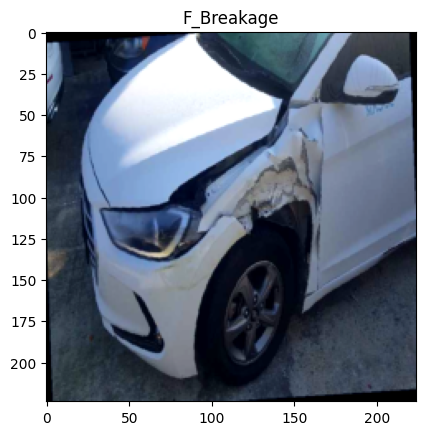

In [60]:
img = image[3]*0.25 + 0.45
lbl = label[3].item()
plt.imshow(img.permute(1,2,0))
plt.title(dataset.classes[lbl])

In [61]:
def imshow(img):
    img = img*0.25 + 0.5
    img = img.permute(1,2,0)
    plt.figure(figsize=(14,2))
    plt.imshow(img)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029475987..1.1600001].


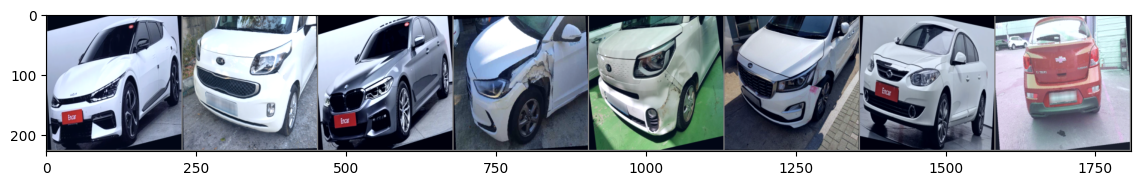

In [62]:
imshow(torchvision.utils.make_grid(image[:8]))

In [63]:
len(train_loader.dataset)

1725

In [64]:
len(train_loader.dataset)

1725

In [65]:
def train_model(model,train_loader,val_loader,criterion,optimiser,epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch,(images,labels) in enumerate(train_loader):
            images,labels = images.to(device),labels.to(device)
            #forward pass
            outputs = model(images)
            loss = criterion(outputs,labels)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            
            #weights updats
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            if (batch+1)%10 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch+1}, Loss: {loss.item():.2f}')
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader.dataset):.4f}')


        model.eval()
        all_pred = []
        all_true = []
        correct = 0
        total = 0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels = images.to(device),labels.to(device)
                outputs = model(images)
                _,pred = torch.max(outputs,1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                all_pred.extend(pred.cpu().numpy())
                all_true.extend(labels.cpu().numpy())

            print(f'*** Accuracy: {100*correct/total:.2f}% ***')
    end = time.time()
    print(f'Execution Time {end-start} seconds')
    return all_true, all_pred

In [66]:
num_classes = len(dataset.classes)
num_classes

6

### Transfer Learning with ResNet

In [67]:
model = models.resnet50(weights='DEFAULT')
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [68]:
class carClassifierCNNResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        #freezing all layers except fc layer
        for param in self.model.parameters():
            param.requires_grad = False

        #unfreezing layer4 we need to train it
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features,num_classes)
        )
    def forward(self,x):
        return self.model(x)
        

In [69]:
def objective(trial):
    lr = trial.suggest_float('lr',1e-5,1e-2,log=True)
    dropout_rate = trial.suggest_float('dropout_rate',0.2,0.7)

    model = carClassifierCNNResNet(num_classes,dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda x:x.requires_grad,model.parameters()),lr=lr)
    
    start = time.time()
    epochs = 3
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch,(images,labels) in enumerate(train_loader):
            images,labels = images.to(device),labels.to(device)
            #forward pass
            outputs = model(images)
            loss = criterion(outputs,labels)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            
            #weights updats
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader.dataset):.4f}')


        model.eval()
        
        correct = 0
        total = 0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels = images.to(device),labels.to(device)
                outputs = model(images)
                _,pred = torch.max(outputs,1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

        accuracy = 100*correct/total

        #Report Intermediate report to optuna
        trial.report(accuracy,epoch)

        #Handle Pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    end = time.time()
    print(f'Execution Time {end-start} seconds')
    return accuracy

In [70]:
start = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=20)
end = time.time()
print(f'Time taken {(end-start)/60} mins')

[I 2025-12-09 22:08:04,402] A new study created in memory with name: no-name-2e099aa4-80e2-4364-ba57-9f3505745020


Epoch [1/3], Loss: 1.1588
Epoch [2/3], Loss: 0.5350
Epoch [3/3], Loss: 0.3417


[I 2025-12-09 22:10:17,687] Trial 0 finished with value: 78.26086956521739 and parameters: {'lr': 0.00022821659971385472, 'dropout_rate': 0.5682573721452844}. Best is trial 0 with value: 78.26086956521739.


Execution Time 132.92167115211487 seconds
Epoch [1/3], Loss: 1.7313
Epoch [2/3], Loss: 1.4686
Epoch [3/3], Loss: 1.0845


[I 2025-12-09 22:12:37,190] Trial 1 finished with value: 66.78260869565217 and parameters: {'lr': 3.23032301320981e-05, 'dropout_rate': 0.5928903105326054}. Best is trial 0 with value: 78.26086956521739.


Execution Time 139.1632649898529 seconds
Epoch [1/3], Loss: 0.8900
Epoch [2/3], Loss: 0.4969
Epoch [3/3], Loss: 0.3336


[I 2025-12-09 22:14:58,287] Trial 2 finished with value: 75.1304347826087 and parameters: {'lr': 0.0015439282338769091, 'dropout_rate': 0.3933992432627304}. Best is trial 0 with value: 78.26086956521739.


Execution Time 140.7636067867279 seconds
Epoch [1/3], Loss: 1.5678
Epoch [2/3], Loss: 0.9464
Epoch [3/3], Loss: 0.6370


[I 2025-12-09 22:17:18,915] Trial 3 finished with value: 72.17391304347827 and parameters: {'lr': 8.245706952399718e-05, 'dropout_rate': 0.6722811239708466}. Best is trial 0 with value: 78.26086956521739.


Execution Time 140.26821279525757 seconds
Epoch [1/3], Loss: 0.9068
Epoch [2/3], Loss: 0.5897
Epoch [3/3], Loss: 0.4187


[I 2025-12-09 22:19:43,057] Trial 4 finished with value: 74.43478260869566 and parameters: {'lr': 0.0052980130558735305, 'dropout_rate': 0.5454387567715797}. Best is trial 0 with value: 78.26086956521739.


Execution Time 143.75459575653076 seconds
Epoch [1/3], Loss: 1.4457


[I 2025-12-09 22:36:11,675] Trial 5 pruned. 


Epoch [1/3], Loss: 1.0664


[I 2025-12-09 22:51:57,184] Trial 6 pruned. 


Epoch [1/3], Loss: 1.4809


[I 2025-12-09 22:52:41,985] Trial 7 pruned. 


Epoch [1/3], Loss: 1.3778


[I 2025-12-09 22:53:26,783] Trial 8 pruned. 


Epoch [1/3], Loss: 1.7281


[I 2025-12-09 22:54:11,529] Trial 9 pruned. 


Epoch [1/3], Loss: 0.8728
Epoch [2/3], Loss: 0.4328
Epoch [3/3], Loss: 0.3631


[I 2025-12-09 22:56:23,863] Trial 10 finished with value: 80.34782608695652 and parameters: {'lr': 0.0009048603708114401, 'dropout_rate': 0.2352458002747255}. Best is trial 10 with value: 80.34782608695652.


Execution Time 132.0074360370636 seconds
Epoch [1/3], Loss: 0.8729
Epoch [2/3], Loss: 0.4608
Epoch [3/3], Loss: 0.3140


[I 2025-12-09 22:58:37,968] Trial 11 finished with value: 76.52173913043478 and parameters: {'lr': 0.0006200749471088311, 'dropout_rate': 0.2353280750843383}. Best is trial 10 with value: 80.34782608695652.


Execution Time 133.75144720077515 seconds
Epoch [1/3], Loss: 0.8557
Epoch [2/3], Loss: 0.4461
Epoch [3/3], Loss: 0.2812


[I 2025-12-09 23:00:53,313] Trial 12 finished with value: 75.47826086956522 and parameters: {'lr': 0.0005939814851442055, 'dropout_rate': 0.20265671819640754}. Best is trial 10 with value: 80.34782608695652.


Execution Time 135.0164098739624 seconds
Epoch [1/3], Loss: 0.8462


[I 2025-12-09 23:01:38,397] Trial 13 pruned. 


Epoch [1/3], Loss: 1.1607
Epoch [2/3], Loss: 0.5546
Epoch [3/3], Loss: 0.3123


[I 2025-12-09 23:03:53,817] Trial 14 finished with value: 73.04347826086956 and parameters: {'lr': 0.0002813833530599547, 'dropout_rate': 0.6783154537889676}. Best is trial 10 with value: 80.34782608695652.


Execution Time 135.06416201591492 seconds
Epoch [1/3], Loss: 0.9957
Epoch [2/3], Loss: 0.4609
Epoch [3/3], Loss: 0.2855


[I 2025-12-09 23:06:12,602] Trial 15 finished with value: 75.82608695652173 and parameters: {'lr': 0.0002958997508758234, 'dropout_rate': 0.2996495165743098}. Best is trial 10 with value: 80.34782608695652.


Execution Time 138.45480394363403 seconds
Epoch [1/3], Loss: 1.7724


[I 2025-12-09 23:06:59,732] Trial 16 pruned. 


Epoch [1/3], Loss: 0.8868


[I 2025-12-09 23:07:46,384] Trial 17 pruned. 


Epoch [1/3], Loss: 0.8680
Epoch [2/3], Loss: 0.4492


[I 2025-12-09 23:09:19,085] Trial 18 pruned. 


Epoch [1/3], Loss: 0.9166
Epoch [2/3], Loss: 0.5291


[I 2025-12-09 23:10:50,514] Trial 19 pruned. 


Time taken 62.768552815914155 mins


In [72]:
study.best_params

{'lr': 0.0009048603708114401, 'dropout_rate': 0.2352458002747255}

In [76]:
study.best_params['dropout_rate']

0.2352458002747255